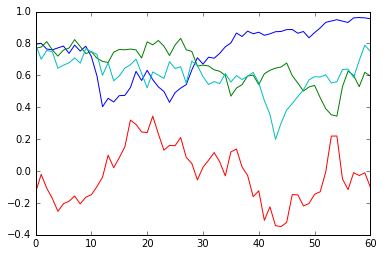

In [1]:
import random as rd
import numpy as np
from itertools import product
from scipy import optimize
import datetime
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd


#Generating pairwise correlations of 10 sectors
M2_S = np.zeros((10,10))
for i,j in product (range(0,10),range(0,10)):
    if (i==j):
        M2_S[i][j] = 1.0
    else:
        if (i>j):
            M2_S[i][j] = rd.uniform(-1.0,1.0)
            M2_S[j][i] = M2_S[i][j]   


#Correlation matrix of 100 stocks based on their sector structure

def tanh(x):
    for (k,i,j) in product(range(0,61), range(0,95), range(0,95)):
        if (i!=j):
            x[k][i][j] = np.tanh(x[k][i][j])


def daily_correlation(sigma):
    daily_corr = np.zeros((61, 95, 95))
    for (i, j) in product (range(0,95), range(0,95)):
        if (i>j):
            daily_corr[0][i][j] = np.random.normal(M2_S[i/10][j/10], sigma, 1)
            daily_corr[0][j][i] = daily_corr[0][i][j]
        else:
            if (i==j):
                daily_corr[0][i][j] = 1.0
        for k in range(1, 61):
            if (i>j):
                daily_corr[k][i][j] = np.random.normal(daily_corr[k-1][i][j], sigma, 1)
                daily_corr[k][j][i] = daily_corr[k][i][j]
            else:
                if (i==j):
                    daily_corr[k][i][j] = 1.0  
    tanh(daily_corr)
    return daily_corr

daily_corr = daily_correlation(0.1)


#Plots showing evolution of the correlations between some stocks
def plots(daily_corr):       
    a,b,c,d = [],[],[],[]
    for i in range (0,61):
        a.append(daily_corr[i][9][94])
        b.append(daily_corr[i][93][94])
        c.append(daily_corr[i][10][11])
        d.append(daily_corr[i][10][12])

    plt.plot(a, 'r', b, 'b', c, 'g', d, 'c')
    plt.show()

    
plots(daily_corr)


#Generating samples of stock returns based on their correlations over 61 days
def return_generator(N_samples, daily_corr):
    mu = np.zeros(95)
    returns = []
    for k in range(0,61):
        returns.append(np.random.multivariate_normal(mu, daily_corr[k], N_samples))
    last_returns = returns[60]
    returns = np.swapaxes(np.delete(returns, 60, axis=0), 0, 1)
    return returns, last_returns


#Empirical models for correlation matrices of stock returns constructed from 60 days
#model1 - straight-forward empirical
#model2 - with respect to the knowledge of underlying sector structure
#r1 - sample returns on the 61st day
def empiric_models(N_samples, daily_corr):
    r0, r1 = return_generator(N_samples, daily_corr)
    model1 = []
    model2 = np.zeros((N_samples, 95, 95))
    sector_average_corr = np.zeros((N_samples, 10, 10))
    for k in range(0, N_samples):
        model1.append(np.corrcoef(r0[k].transpose()))
        for (i,j) in product(range(0,9), range(0,9)):         
            if (i>j):
                sector_average_corr[k][i][j] = np.mean(model1[k][i*10:(i+1)*10, j*10:(j+1)*10])
                sector_average_corr[k][j][i] = sector_average_corr[k][i][j]
            else:
                if (i==j):
                    sector_average_corr[k][i][j] = (np.sum(model1[k][i*10:(i+1)*10, j*10:(j+1)*10])-10)/90
        for i in range(0,9):
            sector_average_corr[k][i][9] = np.mean(model1[k][i*10:(i+1)*10, 90:95])
            sector_average_corr[k][9][i] = sector_average_corr[k][i][9]
        sector_average_corr[k][9][9] = (np.sum(model1[k][90:95, 90:95])-5)/20
        for (i,j) in product(range(0,95), range(0,95)):
            if (i==j):
                model2[k][i][j] = 1.0
            else:
                model2[k][i][j] = sector_average_corr[k][i/10][j/10]
    return model1, model2, r1
    
    
    
#Weights for standard minimum variance Markowitz portfolio
bnds = []
for i in range(0,95):
    bnds.append((0, None))
bnds = tuple(bnds)
cons_sum = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
def portfolio_variance(x, matrix):
    p_var = np.dot(np.dot(x, matrix), x)
    return p_var
def grad_portfolio_var(x, matrix):
    grad = []
    for i in range(0,95):
        s = 2*np.dot(matrix[i], x)
        grad.append(s)
    return grad
def weights(matrix, number_of_weights):
    x0 = (1./number_of_weights)*np.ones(number_of_weights)
    res = optimize.minimize(portfolio_variance, x0, args=(matrix), method = 'SLSQP',
                            jac = grad_portfolio_var, bounds=bnds, constraints=cons_sum,
                            options={'maxiter': 100})
    return res.x


#Error function for sample/out_of_sample as variance of optimal portfolio returns
#range_of_sample - range on which we estimate optimal weights
#out_of_sample range is set to be 200
m2 = np.identity(95)
def error(x, m0, m1, r1):
    portfolio_returns = []
    for k in range (0, len(m0)):
        m = x[0]*m0[k] + x[1]*m1[k] + (1-x[0]-x[1])*m2
        w = weights(m, 95)
        portfolio_returns.append(np.dot(w, r1[k]))
    return np.var(portfolio_returns)


#Optimizing model weights with positivity constraints 
#Function depending on the range_of_sample
cons = ({'type': 'ineq', 'fun': lambda x: x[0]},
       {'type': 'ineq', 'fun': lambda x: x[1]},
       {'type': 'ineq', 'fun': lambda x: 1-x[0]-x[1]})
def optimal_model_weights(m0, m1, r1):
    x0 = [0.5, 0.3]
    start_time = datetime.datetime.now()
    res = optimize.minimize(error, x0, args=(m0, m1, r1), method='COBYLA',
                       constraints=cons,
                       options={'maxiter': 100})
    return datetime.datetime.now() - start_time, res.x, res.fun


def data_for_stumps(sigma_values, samples_per_stump):
    daily_corr = daily_correlation(sigma_values[0])
    m0_all, m1_all, r1_all = empiric_models(samples_per_stump, daily_corr)
    for i in range(1,len(sigma_values)):
        daily_corr = daily_correlation(sigma_values[i])
        m0_upd, m1_upd, r1_upd = empiric_models(samples_per_stump, daily_corr)
        m0_all = np.concatenate((m0_all, m0_upd), 0)
        m1_all = np.concatenate((m1_all, m1_upd), 0)
        r1_all = np.concatenate((r1_all, r1_upd), 0)
    return m0_all, m1_all, r1_all




def three_D_m0(m0_all):
    b = np.zeros((len(m0_all), 95, 95))
    for (k, i, j) in product(range(0, len(m0_all)), range(0, 95), range(0, 95)):
        I = 95*i+j+1
        b[k][i][j] = m0_all[k][I]
    return b

def three_D_m1(m1_all):
    b = np.zeros((len(m1_all), 95, 95))
    for (k, i, j) in product(range(0, len(m1_all)), range(0, 95), range(0, 95)):
        I = 95*i+j+1
        b[k][i][j] = m1_all[k][I]
    return b


In [2]:
I = [20, 27, 34, 40, 46, 52, 59, 66, 73, 79]

def coef_for_sigma_one(sigma, r):
    if (sigma<=sigmas[I[0]]):
        coef = [r[I[0]][0], r[I[0]][1]]
    for i in range(0,9):
        if ((sigma>sigmas[I[i]]) & (sigma<=sigmas[I[i+1]])):
            coef = [(r[I[i]][2]+r[I[i+1]][0])/2, (r[I[i]][3]+r[I[i+1]][1])/2]
    if (sigma>sigmas[I[9]]):
        coef = [r[I[9]][2], r[I[9]][3]]
    return coef

def coef_for_sigma_two(sigma, r):
    if (sigma<=sigmas[I[0]]):
        coef = [np.mean(r[0][I[0]:]), np.mean(r[1][I[0]:])]
    for i in range(I[0], I[9]):
        if ((sigma>sigmas[i]) & (sigma<=sigmas[i+1])):
            coef = [(np.mean(r[2][:(i+1)])+np.mean(r[0][(i+1):]))/2, 
                    (np.mean(r[3][:(i+1)])+np.mean(r[1][(i+1):]))/2]
    if (sigma>sigmas[I[9]]):
        coef = [np.mean(r[2][:(I[9]+1)]), np.mean(r[3][:(I[9]+1)])]
    return coef

def coef_for_sigma_three(sigma,r):
    if (sigma<=sigmas[I[0]]):
        coef = [np.mean(r[0][I[0]:]), np.mean(r[1][I[0]:])]
    for i in range(I[0], I[9]):
        if ((sigma>sigmas[i]) & (sigma<=sigmas[i+1])):
            coef = [(np.sum(r[2][:(i+1)])+np.sum(r[0][(i+1):]))/100, 
                    (np.sum(r[3][:(i+1)])+np.sum(r[1][(i+1):]))/100]
    if (sigma>sigmas[I[9]]):
        coef = [np.mean(r[2][:(I[9]+1)]), np.mean(r[3][:(I[9]+1)])]
    return coef
    
def test_error_one(m0_test, m1_test, r1_test, results, test_sigma_values, samples_per_stump):
    portfolio_returns = []
    for k in range (0, len(test_sigma_values)):
        x = coef_for_sigma_one(test_sigma_values[k], results)
        for j in range(0,samples_per_stump):
            ind = samples_per_stump*k+j
            m = x[0]*m0_test[ind] + x[1]*m1_test[ind] + (1-x[0]-x[1])*m2
            w = weights(m, 95)
            portfolio_returns.append(np.dot(w, r1_test[ind]))
    return np.var(portfolio_returns)

def test_error_two(m0_test, m1_test, r1_test, res, test_sigma_values, samples_per_stump):
    portfolio_returns = []
    for k in range (0, len(test_sigma_values)):
        x = coef_for_sigma_two(test_sigma_values[k], res)
        for j in range(0,samples_per_stump):
            ind = samples_per_stump*k+j
            m = x[0]*m0_test[ind] + x[1]*m1_test[ind] + (1-x[0]-x[1])*m2
            w = weights(m, 95)
            portfolio_returns.append(np.dot(w, r1_test[ind]))
    return np.var(portfolio_returns)

def test_error_three(m0_test, m1_test, r1_test, res, test_sigma_values, samples_per_stump):
    portfolio_returns = []
    for k in range (0, len(test_sigma_values)):
        x = coef_for_sigma_three(test_sigma_values[k], res)
        for j in range(0,samples_per_stump):
            ind = samples_per_stump*k+j
            m = x[0]*m0_test[ind] + x[1]*m1_test[ind] + (1-x[0]-x[1])*m2
            w = weights(m, 95)
            portfolio_returns.append(np.dot(w, r1_test[ind]))
    return np.var(portfolio_returns)




In [3]:
m0_all = pd.read_csv('m0_all.csv', header=None)
m1_all = pd.read_csv('m1_all.csv', header=None)
r1_all = pd.read_csv('r1_all.csv', header=None)

m0_all = m0_all.as_matrix(columns=None)
m1_all = m1_all.as_matrix(columns=None)
r1_all = r1_all.as_matrix(columns=None)
    
m0_all = three_D_m0(m0_all)
m1_all = three_D_m1(m1_all)
r1_all = r1_all[0:2500, 1:96]

time, result, value = optimal_model_weights(m0_all, m1_all, r1_all)

print result


[ 0.31876075  0.41371722]


In [4]:
import ast
results1 = pd.read_csv('results1.csv', header=None)
results2 = pd.read_csv('results2.csv', header=None)
results3 = pd.read_csv('results3.csv', header=None)
results4 = pd.read_csv('results4.csv', header=None)
sigmas = pd.read_csv('sigmas.csv', header=None)[1]
results = np.concatenate((results1[1], results2[1], results3[1], results4[1]), 0)

res = []
for i in range(0,100):
    res.append(ast.literal_eval(results[i]))
results = res

res = []
for i in range(0,4):
    temp = []
    for j in range(0,100):
        temp.append(results[j][i])
    res.append(temp)


In [5]:
test_sigma_values = np.sort(np.random.uniform(0.05, 0.3, 37))

m0_test, m1_test, r1_test = data_for_stumps(test_sigma_values, 25)

error1 = error(result, m0_test, m1_test, r1_test)

print('Error for simple coefficeints')
print error1

error2 = test_error_one(m0_test, m1_test, r1_test, results, test_sigma_values, 25)

print('Error from tree classifier')
print error2

error3 = test_error_two(m0_test, m1_test, r1_test, res, test_sigma_values, 25)

print('Error from the first boosting')
print error3

error4 = test_error_three(m0_test, m1_test, r1_test, res, test_sigma_values, 25)

print('Error from the second boosting')
print error4


C:\Users\Mikhail\Anaconda2\lib\site-packages\ipykernel\__main__.py:74: RuntimeWarning: covariance is not positive-semidefinite.


Error for simple coefficeints
0.0139370455966
Error from tree classifier
0.0138428071163
Error from the first boosting
0.0138978319478
Error from the second boosting
0.0138882071096


In [6]:
test_sigma_values = np.sort(np.random.uniform(0.05, 0.3, 37))

m0_test, m1_test, r1_test = data_for_stumps(test_sigma_values, 25)

error1 = error(result, m0_test, m1_test, r1_test)

print('Error for simple coefficeints')
print error1

error2 = test_error_one(m0_test, m1_test, r1_test, results, test_sigma_values, 25)

print('Error from tree classifier')
print error2

error3 = test_error_two(m0_test, m1_test, r1_test, res, test_sigma_values, 25)

print('Error from the first boosting')
print error3

error4 = test_error_three(m0_test, m1_test, r1_test, res, test_sigma_values, 25)

print('Error from the second boosting')
print error4

C:\Users\Mikhail\Anaconda2\lib\site-packages\ipykernel\__main__.py:74: RuntimeWarning: covariance is not positive-semidefinite.


Error for simple coefficeints
0.01370751704
Error from tree classifier
0.013597485445
Error from the first boosting
0.0136424769869
Error from the second boosting
0.013646747297


In [7]:
test_sigma_values = np.sort(np.random.uniform(0.05, 0.3, 37))

m0_test, m1_test, r1_test = data_for_stumps(test_sigma_values, 25)

error1 = error(result, m0_test, m1_test, r1_test)

print('Error for simple coefficeints')
print error1

error2 = test_error_one(m0_test, m1_test, r1_test, results, test_sigma_values, 25)

print('Error from tree classifier')
print error2

error3 = test_error_two(m0_test, m1_test, r1_test, res, test_sigma_values, 25)

print('Error from the first boosting')
print error3

error4 = test_error_three(m0_test, m1_test, r1_test, res, test_sigma_values, 25)

print('Error from the second boosting')
print error4

C:\Users\Mikhail\Anaconda2\lib\site-packages\ipykernel\__main__.py:74: RuntimeWarning: covariance is not positive-semidefinite.


Error for simple coefficeints
0.0159337693817
Error from tree classifier
0.0158045711293
Error from the first boosting
0.0158585320451
Error from the second boosting
0.0158244564783


In [8]:
test_sigma_values = np.sort(np.random.uniform(0.05, 0.3, 37))

m0_test, m1_test, r1_test = data_for_stumps(test_sigma_values, 25)

error1 = error(result, m0_test, m1_test, r1_test)

print('Error for simple coefficeints')
print error1

error2 = test_error_one(m0_test, m1_test, r1_test, results, test_sigma_values, 25)

print('Error from tree classifier')
print error2

error3 = test_error_two(m0_test, m1_test, r1_test, res, test_sigma_values, 25)

print('Error from the first boosting')
print error3

error4 = test_error_three(m0_test, m1_test, r1_test, res, test_sigma_values, 25)

print('Error from the second boosting')
print error4

C:\Users\Mikhail\Anaconda2\lib\site-packages\ipykernel\__main__.py:74: RuntimeWarning: covariance is not positive-semidefinite.


Error for simple coefficeints
0.0153984776225
Error from tree classifier
0.0152603098172
Error from the first boosting
0.015341530136
Error from the second boosting
0.0153378727982


In [9]:
test_sigma_values = np.sort(np.random.uniform(0.05, 0.3, 37))

m0_test, m1_test, r1_test = data_for_stumps(test_sigma_values, 25)

error1 = error(result, m0_test, m1_test, r1_test)

print('Error for simple coefficeints')
print error1

error2 = test_error_one(m0_test, m1_test, r1_test, results, test_sigma_values, 25)

print('Error from tree classifier')
print error2

error3 = test_error_two(m0_test, m1_test, r1_test, res, test_sigma_values, 25)

print('Error from the first boosting')
print error3

error4 = test_error_three(m0_test, m1_test, r1_test, res, test_sigma_values, 25)

print('Error from the second boosting')
print error4

C:\Users\Mikhail\Anaconda2\lib\site-packages\ipykernel\__main__.py:74: RuntimeWarning: covariance is not positive-semidefinite.


Error for simple coefficeints
0.0143382630374
Error from tree classifier
0.0143319684447
Error from the first boosting
0.0143089633981
Error from the second boosting
0.0143085228578
